In [1]:
import os
import findspark
os.environ['SPARK_HOME'] = '/usr/local/Cellar/apache-spark/2.2.0/libexec/'
findspark.init()
from pyspark import SQLContext, SparkContext
from pyspark.sql import functions as F
import json
import numpy as np

from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

We load the data from the json file. The data is a small subset containing only items from the following categories:
"Baby", "Automotive" and "Grocery and Gourmet Food".

In [3]:
review_df = sqlContext.read.json("reviews_auto_baby_grocery.json")

We get the count of review of distinc article per reviewer and filter those that have less than 5 review.

In [4]:
review_df_count = review_df.groupBy("reviewerID").agg(F.countDistinct("asin").alias('count')).filter("`count` >= 5")

We get all reviews of reviewers with more than 5 articles.

In [5]:
review_df_filtered = review_df.join(review_df_count, on='reviewerID').drop('count')

We compute the average grade for each reviewer.

In [6]:
average_score = review_df_filtered.groupBy("reviewerID").avg("overall").select("avg(overall)")

In [7]:
average_std_score = review_df_filtered.groupBy("reviewerID").agg(F.avg("overall").alias("mean"), F.stddev("overall").alias("std"))
average_std_score.cache().count()

109193

In [8]:
average_std_score.select("mean", "std").describe().show()

+-------+------------------+------------------+
|summary|              mean|               std|
+-------+------------------+------------------+
|  count|            109193|            109193|
|   mean|4.2834718157516365|0.9022456674075624|
| stddev|0.6049040387948184|0.5699621176391938|
|    min|               1.0|               0.0|
|    max|               5.0|2.1908902300206647|
+-------+------------------+------------------+



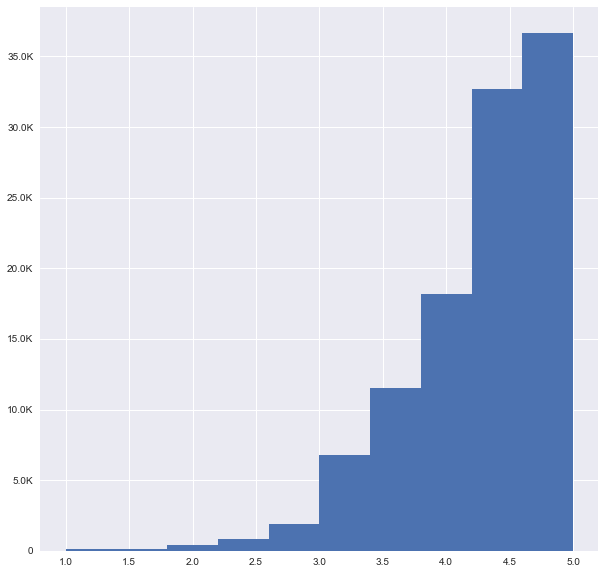

In [9]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.select("mean"));

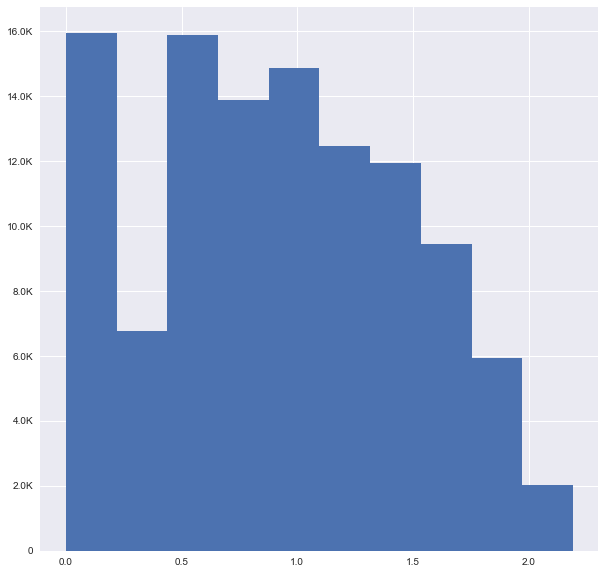

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.select("std"));

Here, we look at the mean of the ratings given by reviewer with small (<0.25) standard deviation.
We also look at what percentage of reviewer they correspond.

There is 14.72% of reviewer with std < 0.25


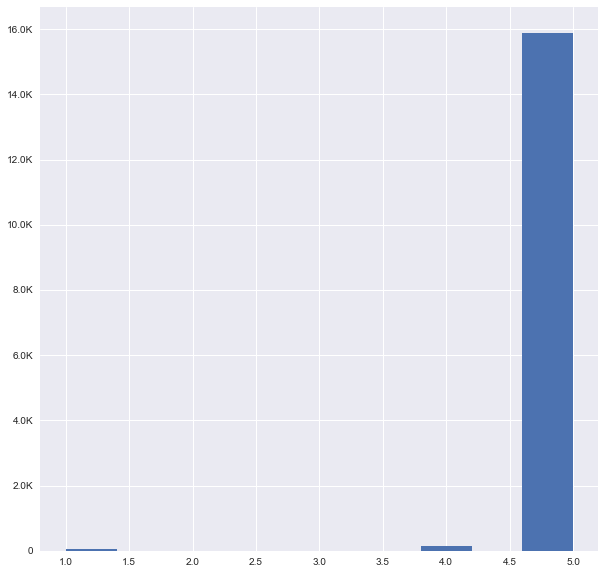

In [11]:
print("There is %.2f%% of reviewer with std < 0.25"%(average_std_score.filter(average_std_score.std < 0.25).count()/average_std_score.count()*100))
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
hist(ax, average_std_score.filter(average_std_score.std < 0.25).select("mean"));

Loading product's metadata.

In [12]:
meta_df = sqlContext.read.json("meta_auto_baby_grocery.json")

Compute the total number of products.

In [13]:
total_products = meta_df.count()
total_products

574167

Remove products that aren't ranked.

In [14]:
filtered_meta_df = meta_df.dropna(subset=['salesRank'])

Compute the ratio between ranked and total products.

Obtain the names of the rank categories.

In [15]:
ranked_products = filtered_meta_df.count()
ranked_products
ratio = ranked_products/total_products
print("ranked_products: " + str(ranked_products) + " total products: " + str(total_products) + " ratio: " + str(ratio))

ranked_products: 160406 total products: 574167 ratio: 0.27937168106143334


In [16]:
rank_categories = filtered_meta_df.head().salesRank.asDict().keys()

For each rank category, take the 5 best ranked products, look in the review table and see how many review were made for each product. Save the values and try to interpet. This part could be expanded.

In [17]:
filtered_meta_df = filtered_meta_df.select('salesRank.*', "asin")

for category in rank_categories:
    category_df = filtered_meta_df.select(category, "asin").dropna().sort(category, ascending = False)
    best_products = category_df.take(5)
    for index, best_product in enumerate(best_products):
        productid = best_product.asin
        rank = best_product.category
        number_reviews = review_df.filter(review_df.asin == productid).count()
        print("There are " + str(number_reviews) + " reviews for the product ranked " + str(rank) + " in the category " + category)

There are 1 reviews for the product ranked 1 in the category Cell Phones & Accessories
There are 1 reviews for the product ranked 2 in the category Cell Phones & Accessories
There are 8 reviews for the product ranked 3 in the category Cell Phones & Accessories
There are 2 reviews for the product ranked 4 in the category Cell Phones & Accessories
There are 1 reviews for the product ranked 5 in the category Cell Phones & Accessories
There are 2 reviews for the product ranked 1 in the category Electronics
There are 1 reviews for the product ranked 2 in the category Electronics
There are 1 reviews for the product ranked 3 in the category Electronics
There are 1 reviews for the product ranked 4 in the category Electronics
There are 3 reviews for the product ranked 5 in the category Electronics
There are 1 reviews for the product ranked 1 in the category Clothing
There are 1 reviews for the product ranked 2 in the category Clothing
There are 2 reviews for the product ranked 3 in the category

There are 1 reviews for the product ranked 1 in the category Video Games
There are 4 reviews for the product ranked 2 in the category Video Games
There are 1 reviews for the product ranked 3 in the category Video Games
There are 2 reviews for the product ranked 4 in the category Video Games
There are 1 reviews for the product ranked 5 in the category Video Games
There are 1 reviews for the product ranked 1 in the category Kitchen & Dining
There are 1 reviews for the product ranked 2 in the category Kitchen & Dining
There are 1 reviews for the product ranked 3 in the category Kitchen & Dining
There are 1 reviews for the product ranked 4 in the category Kitchen & Dining
There are 1 reviews for the product ranked 5 in the category Kitchen & Dining
There are 2 reviews for the product ranked 1 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 2 in the category Patio, Lawn & Garden
There are 1 reviews for the product ranked 3 in the category Patio, Lawn & Garden

In [ ]:
#TODO: tackle the 'influence of "also bought..." feature' and 'product categorization questions.